<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [32]:
%matplotlib inline

from __future__ import division, print_function

import warnings
import pickle
import os

import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm
from glob import glob

from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', 25)
PATH_TO_DATA = '../data/capstone_user_identification/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
        
    next_user_id = 1
    rows = []
    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        
        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)

        for idx in range(0, session_count):
            
            bound = min(idx *  window_size + session_length, len(sites))
            
            current_session = [site_freq[s][0] for s in sites[idx * window_size : bound]]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]
            
            seconds = (sessions_timestamps[len(sessions_timestamps) - 1] - sessions_timestamps[0]).seconds
            hour = sessions_timestamps[0].hour
            day = sessions_timestamps[0].dayofweek
            unique = len(set(current_session))
            
            if len(current_session) < 10:
                current_session = current_session + [0] * (10 - len(current_session))
            
            row = current_session + [seconds] + [unique] + [hour] + [day] + [next_user_id]
            rows.append(row)
            
        next_user_id = next_user_id + 1
    
    return pd.DataFrame(rows, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'user_id']
train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.01it/s]


Wall time: 366 ms


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


Wall time: 5.61 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,1
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,1
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,1
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,1
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:55<00:00,  3.82it/s]


Wall time: 56.7 s


In [9]:
train_data_150users[train_data_150users.columns[10:14]].head()

,session_timespan,#unique_sites,start_hour,day_of_week
0,57,5,8,4
1,1618,8,8,4
2,2010,5,8,4
3,2006,4,9,4
4,10,5,9,4


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[train_data_10users.columns[10:14]] #''' ВАШ КОД ЗДЕСЬ '''
new_features_150users = train_data_150users[train_data_150users.columns[10:14]] #''' ВАШ КОД ЗДЕСЬ '''

In [11]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
# id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
#                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

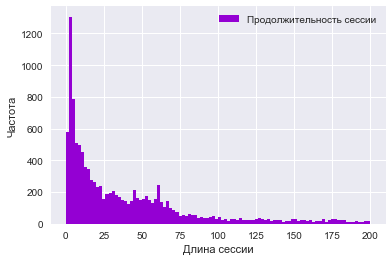

In [14]:
hist = train_data_10users['session_timespan'].hist(range=(0, 200), bins=100, color='darkviolet', label = 'Продолжительность сессии')
hist.set(xlabel="Длина сессии", ylabel="Частота")
hist.legend()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

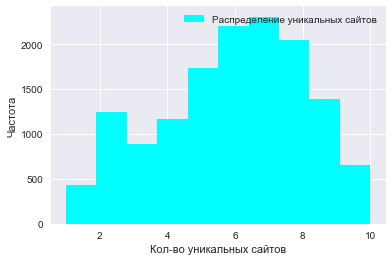

In [15]:
hist = train_data_10users['#unique_sites'].hist(bins=10, color='aqua', label = 'Распределение уникальных сайтов')
hist.set(xlabel="Кол-во уникальных сайтов", ylabel="Частота")
hist.legend()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

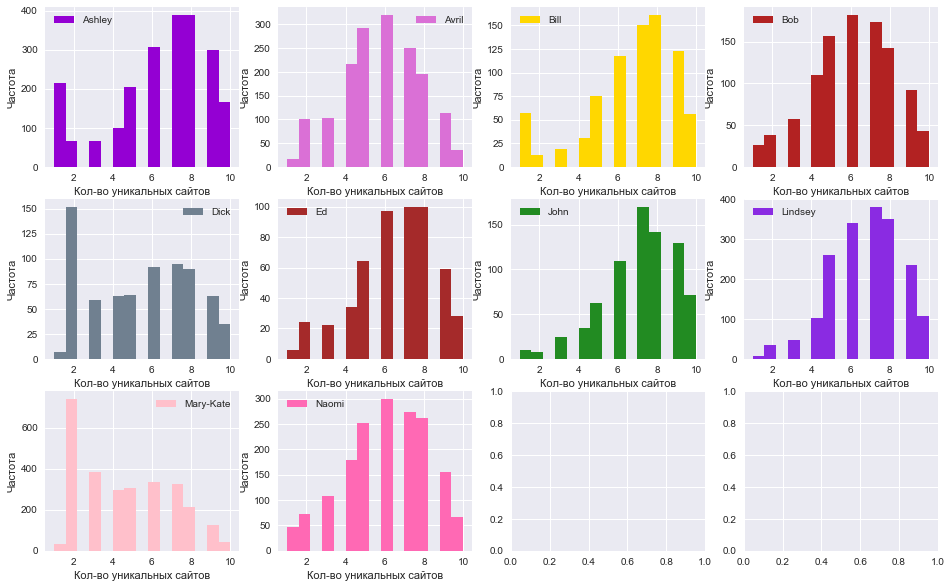

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['#unique_sites'], bins=15, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="Кол-во уникальных сайтов", ylabel="Частота")
    axes_flatten[idx].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

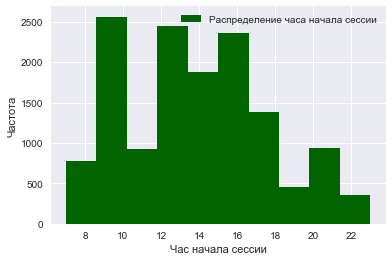

In [17]:
hist = train_data_10users['start_hour'].hist(bins=10, color='darkgreen', label = 'Распределение часа начала сессии')
hist.set(xlabel="Час начала сессии", ylabel="Частота")
hist.legend()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

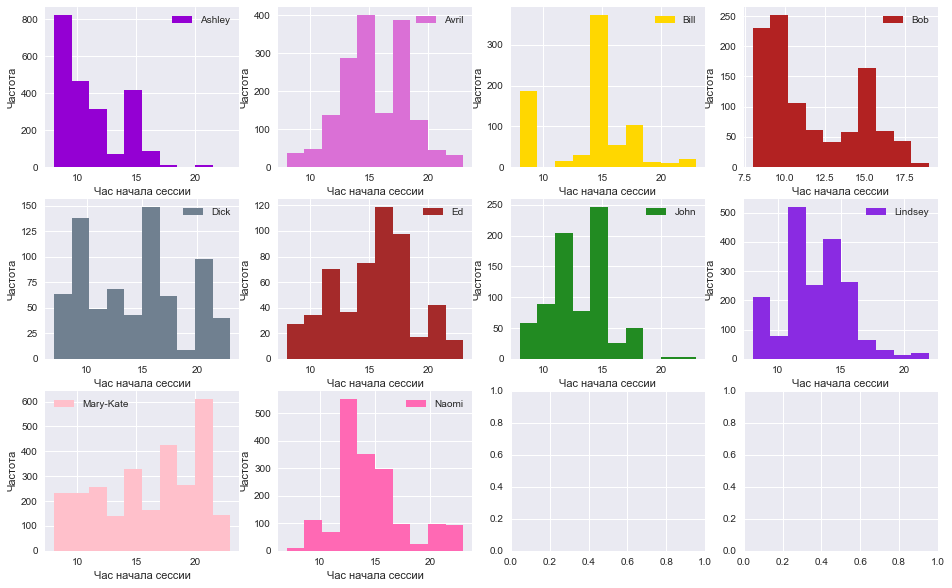

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['start_hour'], bins=10, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="Час начала сессии", ylabel="Частота")
    axes_flatten[idx].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

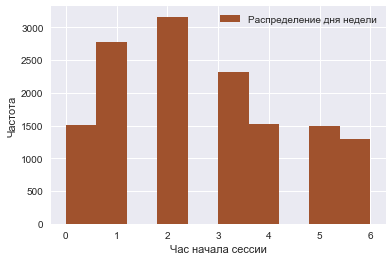

In [19]:
hist = train_data_10users['day_of_week'].hist(bins=10, color='sienna', label = 'Распределение дня недели')
hist.set(xlabel="Час начала сессии", ylabel="Частота")
hist.legend()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

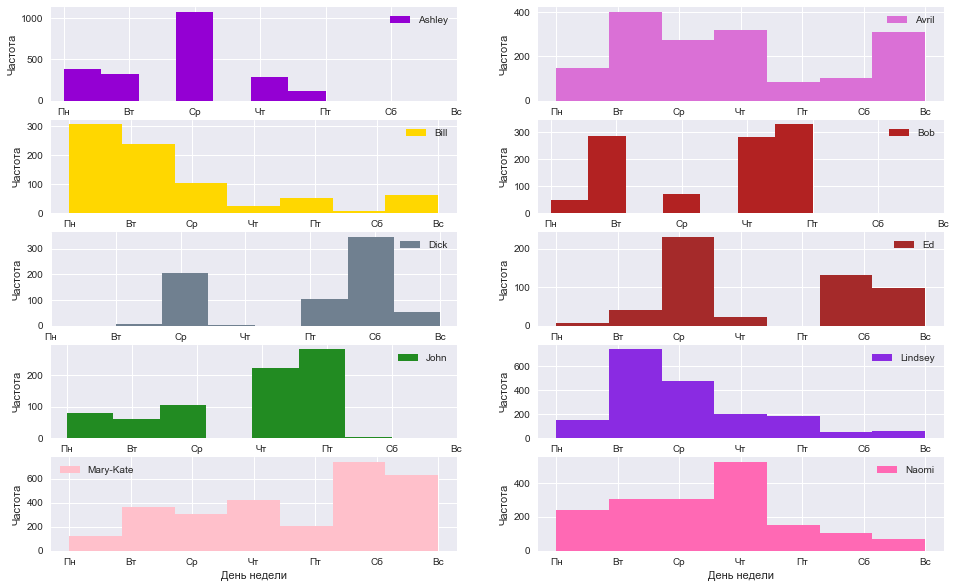

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))

axes_flatten = axes.flatten()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['day_of_week'], bins=7, align='mid', color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="День недели", ylabel="Частота", xticklabels=days, xticks=np.arange(len(days)))
    axes_flatten[idx].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По построенным графикам можно сделать следующие выводы:
 * Все пользователи посещают примерно 6-8 различных сайтов за сессию, хотя есть и исключение, например Mary-Kate
 * Пользователи значительно различаются по времени старта сессий, кто-то сидит в интернете больше по утрам, кто-то в течении всего дня (предположу что это так же может зависеть от рода деятельности пользователя)
 * По гистограммам распределения дня начала сессии можно утверждать что пользователи на удивление сидят в интернете больше в рабочие дни, чем в выходные.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with (open(site_freq_path, 'rb')) as file:
    site_freq = pickle.load(file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_sites = sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:10]
top10_freqs = [site_freq[s][1] for s in top10_sites]

print(top10_sites)
print()
print(top10_freqs)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

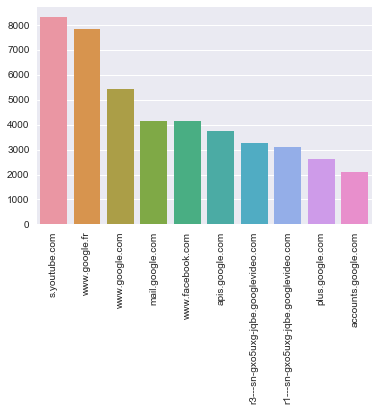

In [23]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
def get_top(site_freq, token, top):
    count = Counter([x.split('.')[token:][0] for x in site_freq])
    return pd.Series(count).sort_values(ascending=False).index[:top]

In [29]:
def extract_part_of_day_and_season(date):
    part_of_day = 0
    season = 0
    
    if date.hour > 1 and date.hour < 8:
        part_of_day = 1
    elif date.hour > 8 and date.hour < 18:
        part_of_day = 2
    else:
        part_of_day = 3

    season = 1 if date.month == 12 else date.month // 3 + 1
        
    return part_of_day, season

In [30]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
        
    first_level = get_top(site_freq, -1, 1)    
    second_level = get_top(site_freq, -2, 10)    
    top50_ids = [site_freq[s][0] for s in sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:50]]
        
    next_user_id = 1
    rows = []
    
    feature_names = ['average_time', 'popular_sites', 'fl', 'sl', 'part_of_day', 'season', 'user_id']
    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):

        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values
        
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)
        
        for idx in range(0, session_count):
            
            bound = min(idx *  window_size + session_length, len(sites))
            
            current_session = sites[idx * window_size : bound]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]
            
            counts_pop_sites = sum([site_freq[s][0] in top50_ids for s in current_session])
            avg = np.array([(sessions_timestamps[idx + 1] - sessions_timestamps[idx]).seconds \
                            for idx, _ in enumerate(sessions_timestamps) if idx + 1 != len(sessions_timestamps)]).mean()
            popular_first = sum([s.split('.')[-1:][0] in first_level for s in current_session])
            popular_second = sum([s.split('.')[-2:][0] in second_level for s in current_session])
            
            part_of_day, season = extract_part_of_day_and_season(sessions_timestamps[0])
            
            row = [avg, counts_pop_sites, popular_first, popular_second, part_of_day, season, next_user_id]
            rows.append(row)
            
        next_user_id = next_user_id + 1
    
    return pd.DataFrame(rows, columns=feature_names)

In [33]:
%%time
feature_engineering(os.path.join(PATH_TO_DATA, '3users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  session_length=10)

100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.84it/s]


Wall time: 25 ms


,average_time,popular_sites,fl,sl,part_of_day,season,user_id
0,888.666667,10,9,10,2,4,1
1,20.000000,4,4,4,2,4,1
2,1983.750000,5,3,5,2,4,2
3,888.666667,10,7,10,2,4,3
4,735.500000,3,2,3,2,4,3


In [36]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  session_length=10) 

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07s/it]


Wall time: 10 s


In [37]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:35<00:00,  2.15it/s]


Wall time: 1min 36s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [38]:
def hist(col, nrows=5, ncols=2, bins=10):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))

    axes_flatten = axes.flatten()

    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
        axes_flatten[idx].hist(sub_df[col], bins=bins, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
        axes_flatten[idx].legend()

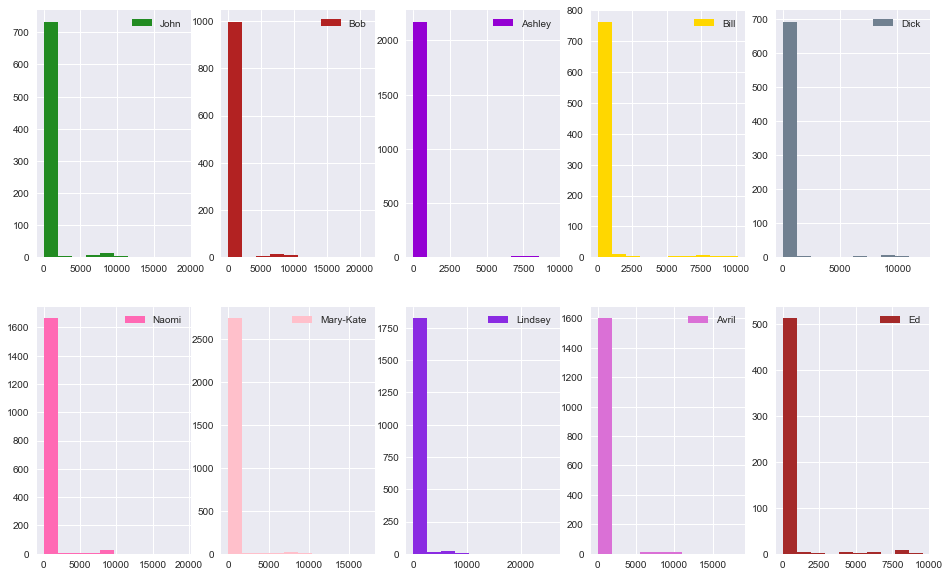

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['average_time'].dropna(), bins=10, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
    axes_flatten[idx].legend()

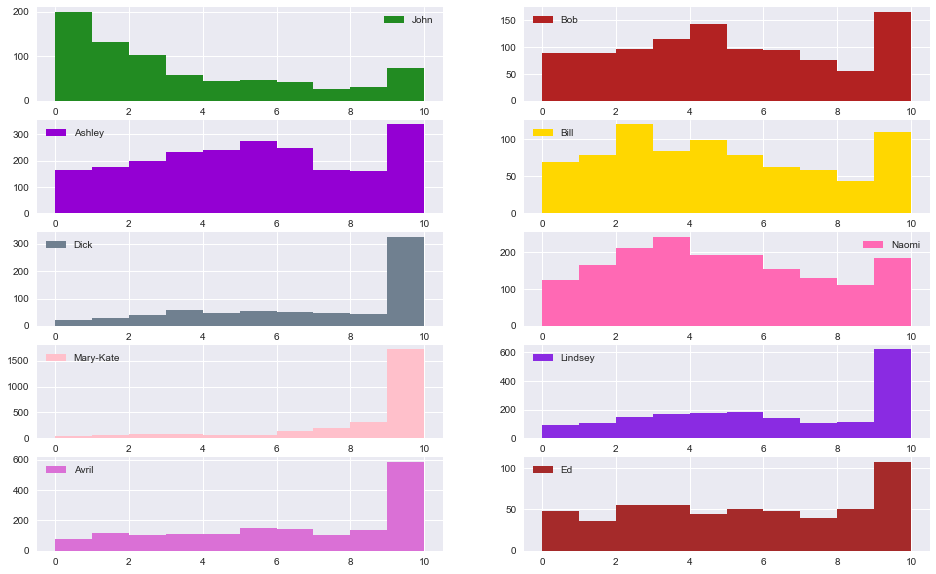

In [40]:
hist('popular_sites')

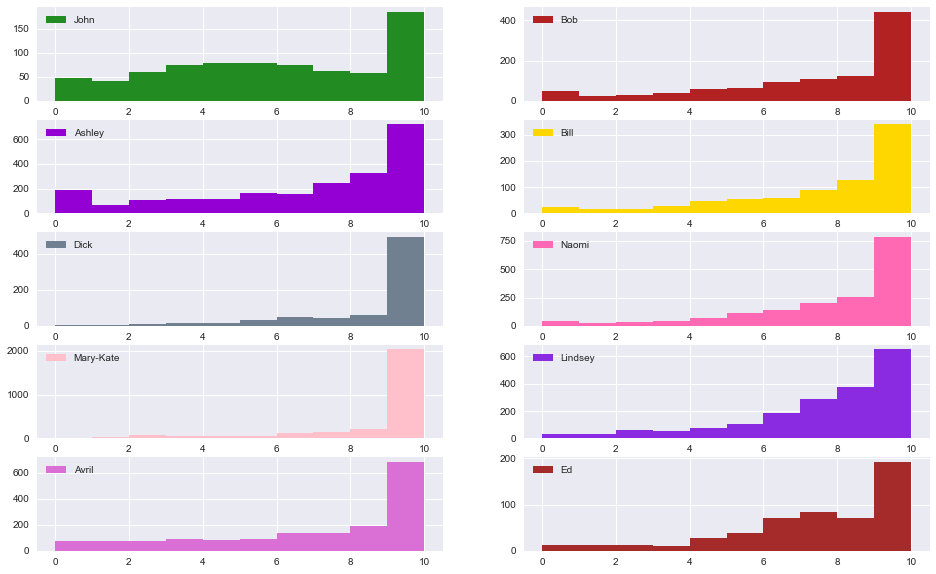

In [41]:
hist('fl')

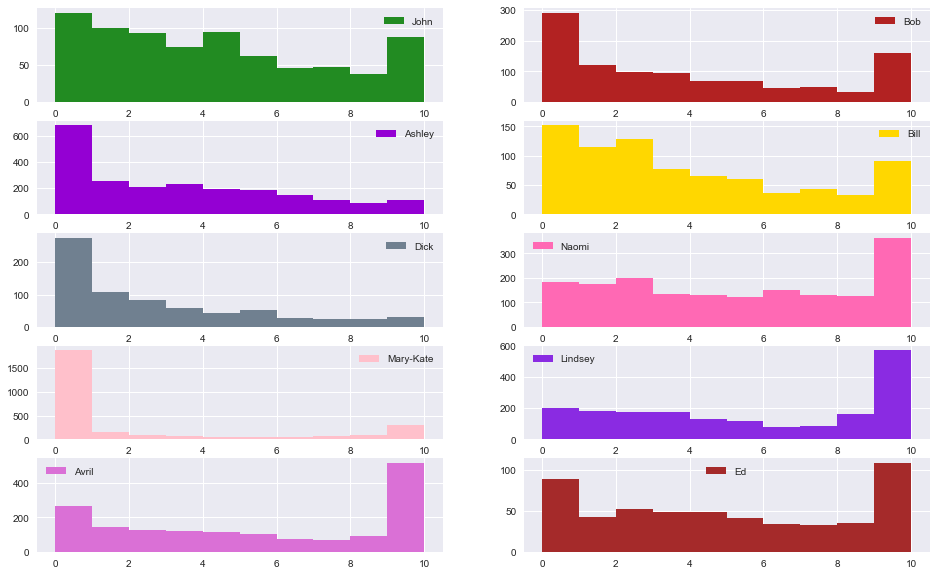

In [42]:
hist('sl')

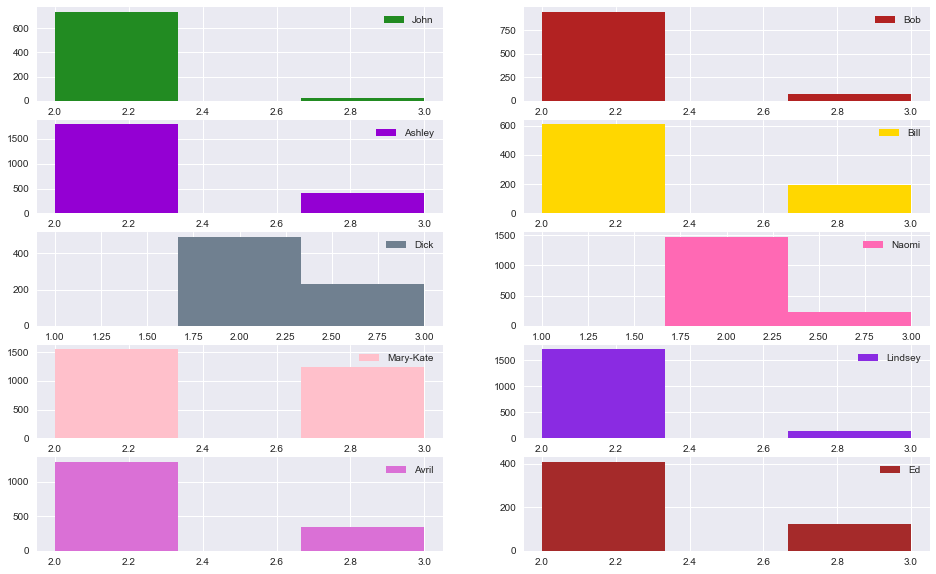

In [43]:
hist('part_of_day', bins=3)

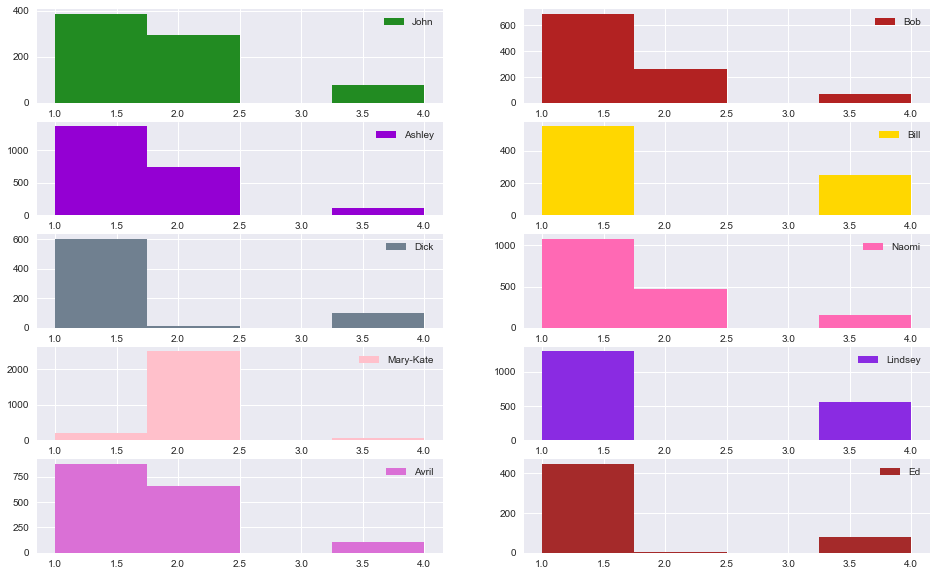

In [44]:
hist('season', bins=4)

In [45]:
temp = pd.concat([train_data_10users[train_data_10users.columns[:-1]], new_features_10users], axis=1)
temp.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,average_time,popular_sites,fl,sl,part_of_day,season,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,3.666667,2,3,2,3,4,1
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31.555556,1,7,2,3,4,1
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,28.666667,2,6,2,3,4,1
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,3.333333,0,2,1,3,4,1
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,0.666667,1,3,5,3,4,1


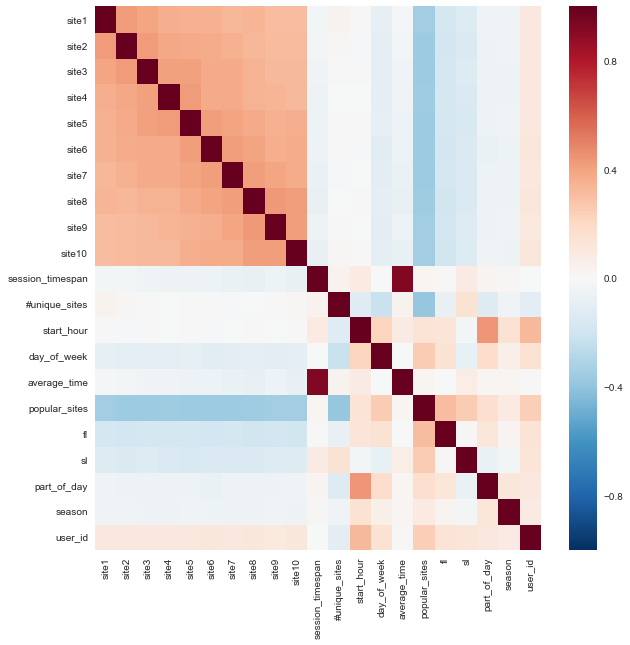

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(temp.corr())

Были проанализированы новые признаки:
 * Среднее время на сайте
 * Кол-во сайтов из топ 50 в одной сессии
 * Посещение домена com 
 * Посещение top 10 доменов второго уровня
 * Время суток (утро, рабочее время, вечер)
 * Время года
 
Из гистограмм видно что маловероятно что первый признак может принести пользу в обучении модели.
А вот с остальными можно попробовать поработать, хотя по некоторым из них так же имеются большие сомнения.
Так же следует отметить что как и ожидалось среднее время проведенное на сайте илнейно зависимо от полного времени сессии

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [47]:
selected_features_10users = new_features_10users[new_features_10users.columns[1:]] 
selected_features_150users = new_features_150users[new_features_150users.columns[1:]] 

In [48]:
with open(os.path.join(PATH_TO_DATA, 'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 